# Logic Gates



<hr>

Let's load some libraries we will need.

In [236]:
import numpy as np
import scipy.integrate
import scipy.optimize

import matplotlib.pyplot as plt
%matplotlib inline

figsize=(6, 4.5)

## The Inverter

Let us quickly recall the inverter (`INV` gate) that negates an input `X` resulting in an output `Z = NOT(X)`.

We will use the Python library [dnaplotlib](https://github.com/VoigtLab/dnaplotlib) for plotting circuits.
The library uses the [SBOL](https://en.wikipedia.org/wiki/Synthetic_Biology_Open_Language) standard for symbols.
You can find an overview on the supported symbols at their [visual glyphs page](https://sbolstandard.org/visual-glyphs/).

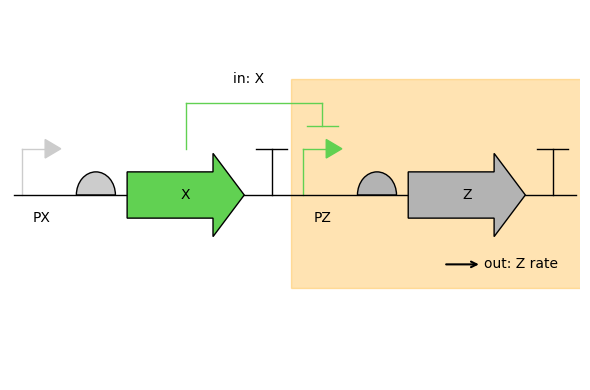

In [237]:
# %pip install dnaplotlib
import dnaplotlib as dpl

# Create DNA renderer
dr = dpl.DNARenderer()
renderers = dr.SBOL_part_renderers()

# --- Define design ---
# --- A gate ---
p0 = {
        'type': 'Promoter',
        'fwd': True,
        'opts': {
            'label':'PX',
            'label_size':10,
            'label_y_offset': -5,
            'color':[0.8, 0.8, 0.8],
        },
    }
rbs0 = {
        'type': 'RBS',
        'fwd': True,
        'opts': {
            'color':[0.8, 0.8, 0.8],
        }
    }
cds0 = {
        'type': 'CDS',
        'fwd': True,
        'opts': {
            'color':[0.38, 0.82, 0.32],
            'label':'X',
            'label_size':10
        },
    }
t0 = {
        'type': 'Terminator',
        'fwd': True,
    }

# --- inverter gate ---
p2 = {
        'type': 'Promoter',
        'fwd': True,
        'opts': {
            'color': [0.38, 0.82, 0.32],
            'label': 'PZ',
            'label_size':10,
            'label_y_offset': -5
        },
    }
rbs2 = {
        'type': 'RBS',
        'fwd': True,
    }
cds2 = {
        'type': 'CDS',
        'fwd': True,
        'opts': {
            'label':'Z',
            'label_size':10
        },
    }
t2 = {
        'type': 'Terminator',
        'fwd': True,
    }

# --- Define regulation ---
regulations = [
    {
        'from_part': cds0,
        'to_part': p2,
        'type': 'Repression',
        'opts': {
            'color': [0.38, 0.82, 0.32],
        }
    }
]

design = [
    p0, rbs0, cds0, t0,
    p2, rbs2, cds2, t2,
]

# --- Render DNA ---
fig, ax = plt.subplots(figsize=(6, 4))

# orange gate box
gate_x = [71, 71, 150, 150]
gate_y = [25, -20, -20, 25]
ax.fill(gate_x, gate_y, color='orange', alpha=0.3)

start_pos, end_pos = dr.renderDNA(
    ax=ax,
    parts=design,
    regs=regulations,
    part_renderers=renderers,
    reg_renderers= dr.std_reg_renderers(),
)

ax.annotate(
    'in: X',
    xy=(60, 25),
    xytext=(60, 25),
    fontsize=10,
    ha='center',
    va='center'
)
ax.annotate(
    'out: Z rate',
    xy=(110, -15),
    xytext=(130, -15),
    arrowprops=dict(arrowstyle="<-", color='black', lw=1.5),
    fontsize=10,
    ha='center',
    va='center'
)

ax.set_xlim(start_pos - 1, end_pos + 1)
ax.set_ylim(-40, 40)
ax.set_axis_off()
plt.tight_layout()

Conceptually, here, the gate starts after CDS X, with the concentration X being the input, and ends with CDS Z, with the production rate of Z being the output.
We mark the components that belong to the gate in orange.

We had approximated the stead-state expression rate of the output gene $Z$ with a Hill function:

\begin{align}
\beta(X) = \beta_{\max} \frac{1}{1+X/K_\mathrm{d}}
\end{align}

where $\beta_{\max}$ is the maximal production rate and $K_d$ the dissociation constant $k_-/k_+$.
Generalizing this to higher order Hill coefficients $n \geq 1$ we can write
\begin{align}
  \beta(X) = \beta_{\max} \frac{1}{1+(X/K_\mathrm{d})^n}
\end{align}
The result is a sharper, say "more digital", dependency of the production rate with respect to
the repressor $X$.

> **_Side note:_** While we derived the approximation for $n=1$ for activation and repression in previous lectures, the case $n > 1$ is only phenomenologically, here. One can, however, derive the case for larger $n$ as an approximation of certain types of activation and repression, e.g., with so-called cooperativity.

We are further including some leaky production rate that we will specify via a minimal and maximal production rate

\begin{align}
  \beta(X) = \beta_{\min} + \frac{\beta_{\max} - \beta_{\min}}{1+(X/K_\mathrm{d})^n}
\end{align}

One readily verifies that the inverter is consistent with the operational corners: $\beta(0) = \beta_{\max}$ (= logical `1`) and $\lim_{X \to \infty} \beta(X) = \beta_{\min}$ (= logical `0`).

Further, observe that the input domain (concentrations or counts) is $[0, \infty)$ and the output domain (rates) is $[\beta_{\min},\beta_{\max}]$. This is not to be confused with classical digital circuits where we could expect all signals to be in a normalized $[0,1]$.

Let us visualize the steady-state of the output vs. the input. One calls this the __transfer characteristics__ or __transfer function__ of the gate.

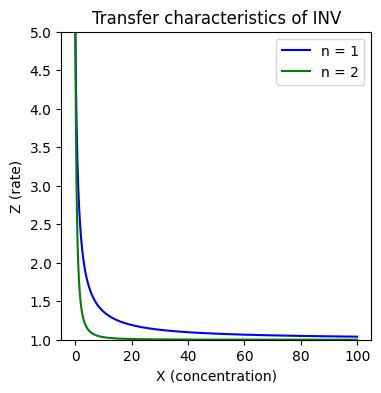

In [238]:
def inv(x: np.ndarray, Kd : float = 1.0, n : float = 1.0, beta_min : float = 1.0, beta_max : float = 5.0) -> np.ndarray:
    return beta_min + (beta_max - beta_min) / (1 + x / Kd)**n

x = np.linspace(0, 100, 10000)
plt.figure(figsize=(4,4))
ax = plt.gca()
plt.plot(x, inv(x, n= 1.0), 'blue', label='n = 1')
plt.plot(x, inv(x, n= 2.0), 'green', label='n = 2')
ax.set_ylim(1, 5)
plt.title("Transfer characteristics of INV")
plt.xlabel("X (concentration)")
plt.ylabel("Z (rate)")
plt.legend()

There is not much visible in a linear plot, so let us visualize the transfer characteristics in a log-log plot to see the behavior for low as well as for high input concentrations.

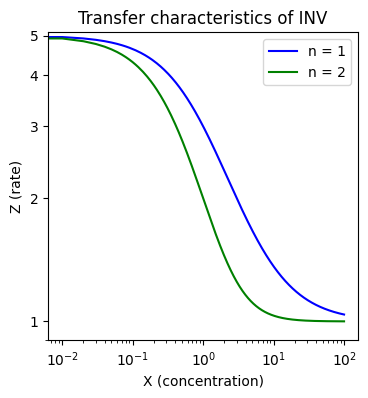

In [239]:
x = np.linspace(0, 100, 10000)
plt.figure(figsize=(4,4))
ax = plt.gca()
plt.plot(x, inv(x, n= 1.0), 'blue', label='n = 1')
plt.plot(x, inv(x, n= 2.0), 'green', label='n = 2')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(0.9, 5.1)
ax.set_yticks(range(1,6),labels=range(1,6))
plt.title("Transfer characteristics of INV")
plt.xlabel("X (concentration)")
plt.ylabel("Z (rate)")
plt.legend()

### Changing the Input and Output Signal

There is a problem though with this characterization of gates. How do we compose gates with the input being in terms of concentrations and the output in terms of an expression rate.

A solution is to "box" the gate differently. We can as well consider the inputs to be the promoter activity (a rate) of the PX promoter. The promoter PX itself is not part of the gate.
For consistency, we can then also choose the promoter activity of PZ as the output signal.
While the output promoter activity will probably be proportional to the expression rate of Z, the rates may be not identical (RNAPs may prematurely stop).

Promoter activity may be measured in several units. Examples are RNAP/s or relative measures like Relative Promoter Units (RPU).

Now we can nicely compose gates. Let's visualize the new understanding of an `INV` gate:

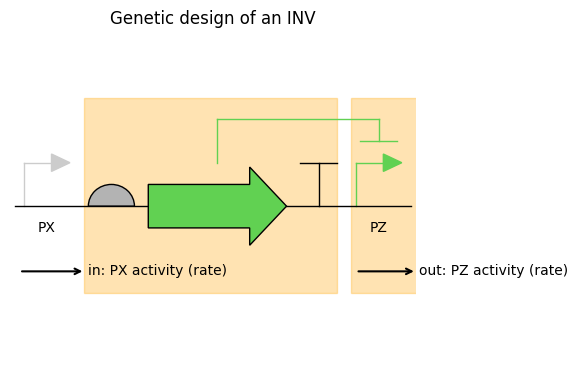

In [240]:
# --- Define design ---
# --- A gate ---
p0 = {
        'type': 'Promoter',
        'fwd': True,
        'opts': {
            'label':'PX',
            'label_size':10,
            'label_y_offset': -5,
            'color':[0.8, 0.8, 0.8],
        },
    }
rbs0 = {
        'type': 'RBS',
        'fwd': True,
    }
cds0 = {
        'type': 'CDS',
        'fwd': True,
        'opts': {
            'color':[0.38, 0.82, 0.32],
            'label_size':10
        },
    }
t0 = {
        'type': 'Terminator',
        'fwd': True,
    }

# --- inverter gate ---
p2 = {
        'type': 'Promoter',
        'fwd': True,
        'opts': {
            'color': [0.38, 0.82, 0.32],
            'label': 'PZ',
            'label_size':10,
            'label_y_offset': -5
        },
    }

# --- Define regulation ---
regulations = [
    {
        'from_part': cds0,
        'to_part': p2,
        'type': 'Repression',
        'opts': {
            'color': [0.38, 0.82, 0.32],
        }
    }
]

design = [
    p0, rbs0, cds0, t0,
    p2,
]

# --- Render DNA ---
fig, ax = plt.subplots(figsize=(6, 4))

# orange gate boxes
gate_x = [15, 15, 70, 70]
gate_y = [25, -20, -20, 25]
ax.fill(gate_x, gate_y, color='orange', alpha=0.3)

gate_x2 = [73, 73, 150, 150]
gate_y2 = [25, -20, -20, 25]
ax.fill(gate_x2, gate_y2, color='orange', alpha=0.3)

start_pos, end_pos = dr.renderDNA(
    ax=ax,
    parts=design,
    regs=regulations,
    part_renderers=renderers,
    reg_renderers= dr.std_reg_renderers(),
)

ax.annotate(
    'in: PX activity (rate)',
    xy=(1, -15),
    xytext=(31, -15),
    arrowprops=dict(arrowstyle="<-", color='black', lw=1.5),
    fontsize=10,
    ha='center',
    va='center'
)
ax.annotate(
    'out: PZ activity (rate)',
    xy=(74, -15),
    xytext=(104, -15),
    arrowprops=dict(arrowstyle="<-", color='black', lw=1.5),
    fontsize=10,
    ha='center',
    va='center'
)

ax.set_xlim(start_pos - 1, end_pos + 1)
ax.set_ylim(-40, 40)
ax.set_axis_off()
plt.title("Genetic design of an INV")
plt.tight_layout()

The gate has two constructs that can be placed on different positions on the DNA.

Like, before, a leaky Hill model turns out to be a good approximation for the transfer characteristics of the `INV` gate.

\begin{align}
  Z(X) = Z_{\min} + \frac{Z_{\max} - Z_{\min}}{1+(X/K_\mathrm{d})^n}
\end{align}

Let us verify that the function correctly captures an `INV`.

| X | expected Z | model Z |
|:-:|:-:|:--|
| low $X$ = `0` | `1` | $ Z(0) = Z_{\max} = $ `1` |
| high $X$ = `1` | `0` | $ \lim_{X \to \infty} Z(X) = Z_{\min} = $ `0` |


## The NOR gate

Let us generalize the `INV` to a 2 input gate.
Nothing prevents us from expressing X from two different input promoters.

Such a design would look like this:

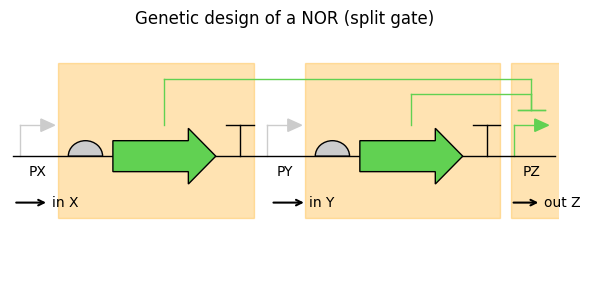

In [241]:
# --- Define design ---
# --- A gate ---
p0 = {
        'type': 'Promoter',
        'fwd': True,
        'opts': {
            'label':'PX',
            'color':[0.8, 0.8, 0.8],
            'label_size':10,
            'label_y_offset': -5
        },
    }
rbs0 = {
        'type': 'RBS',
        'fwd': True,
        'opts': {
            'color':[0.8, 0.8, 0.8],
        }
    }
cds0 = {
        'type': 'CDS',
        'fwd': True,
        'opts': {
            'color':[0.38, 0.82, 0.32],
            'label_size':10
        },
    }
t0 = {
        'type': 'Terminator',
        'fwd': True,
    }

# --- B gate ---
p1 = {
        'type': 'Promoter',
        'fwd': True,
        'opts': {
            'label':'PY',
            'label_size':10,
            'label_y_offset': -5,
            'color':[0.8, 0.8, 0.8],
        },
    }
rbs1 = {
        'type': 'RBS',
        'fwd': True,
        'opts': {
            'color':[0.8, 0.8, 0.8],
        }
    }
cds1 = {
        'type': 'CDS',
        'fwd': True,
        'opts': {
            'color':[0.38, 0.82, 0.32],
            'label_size':10
        },
    }
t1 = {
        'type': 'Terminator',
        'fwd': True,
    }

# --- inverter gate ---
p2 = {
        'type': 'Promoter',
        'fwd': True,
        'opts': {
            'color': [0.38, 0.82, 0.32],
            'label': 'PZ',
            'label_size': 10,
            'label_y_offset': -5
        },
    }

# --- Define regulation ---
regulations = [
    {
        'from_part': cds0,
        'to_part': p2,
        'type': 'Repression',
        'opts': {
            'color': [0.38, 0.82, 0.32],
        }
    },
    {
        'from_part': cds1,
        'to_part': p2,
        'type': 'Repression',
        'opts': {
            'color': [0.38, 0.82, 0.32],
        }
    }
]

design = [
    p0, rbs0, cds0, t0,
    p1, rbs1, cds1, t1,
    p2,
]

# --- Render DNA ---
fig, ax = plt.subplots(figsize=(6, 3))

# orange gate boxes
gate_x = [13, 13, 70, 70]
gate_y = [30, -20, -20, 30]
ax.fill(gate_x, gate_y, color='orange', alpha=0.3)

gate_x2 = [85, 85, 142, 142]
gate_y2 = [30, -20, -20, 30]
ax.fill(gate_x2, gate_y2, color='orange', alpha=0.3)

gate_x3 = [145, 145, 160, 160]
gate_y3 = [30, -20, -20, 30]
ax.fill(gate_x3, gate_y3, color='orange', alpha=0.3)

start_pos, end_pos = dr.renderDNA(
    ax=ax,
    parts=design,
    regs=regulations,
    part_renderers=renderers,
    reg_renderers= dr.std_reg_renderers(),
)

ax.annotate(
    'in X',
    xy=(0, -15),
    xytext=(15, -15),
    arrowprops=dict(arrowstyle="<-", color='black', lw=1.5),
    fontsize=10,
    ha='center',
    va='center'
)
ax.annotate(
    'in Y',
    xy=(75, -15),
    xytext=(90, -15),
    arrowprops=dict(arrowstyle="<-", color='black', lw=1.5),
    fontsize=10,
    ha='center',
    va='center'
)
ax.annotate(
    'out Z',
    xy=(145, -15),
    xytext=(160, -15),
    arrowprops=dict(arrowstyle="<-", color='black', lw=1.5),
    fontsize=10,
    ha='center',
    va='center'
)

ax.set_xlim(start_pos - 1, end_pos + 1)
ax.set_ylim(-40, 40)
ax.set_axis_off()
plt.title("Genetic design of a NOR (split gate)")
plt.tight_layout()


This design is called the __Split Gate__ design, as opposed to another design that we will discuss in a second.

With the concentrations of the repressors adding up, a simple summation of input rates $X$ and $Y$ is a plausible assumption.
In this case we obtain

\begin{align}
  Z(X, Y) &= Z_{\min} + \frac{Z_{\max} - Z_{\min}}{1+((X + Y)/K_\mathrm{d})^n}
\end{align}

Let us verify that the function correctly captures a `NOR`.

| X | Y | expected Z | model Z |
|:-:|:-:|:-:|:--|
| low $X$ = `0` | low $X$ = `0` | `1` | $ Z(0,0) = Z_{\max} = $ `1` |
| low $X$ = `0` | high $X$ = `1` | `0` | $ \lim_{Y \to \infty} Z(X,Y) = Z_{\min} = $ `0` |
| high $X$ = `1` | low $X$ = `0` | `0` | $ \lim_{X \to \infty} Z(X,Y) = Z_{\min} = $ `0` |
| high $X$ = `1` | high $X$ = `1` | `0` | $ \lim_{X,Y \to \infty} Z(X,Y) = Z_{\min} = $ `0` |

We can plot the steady-state of this function

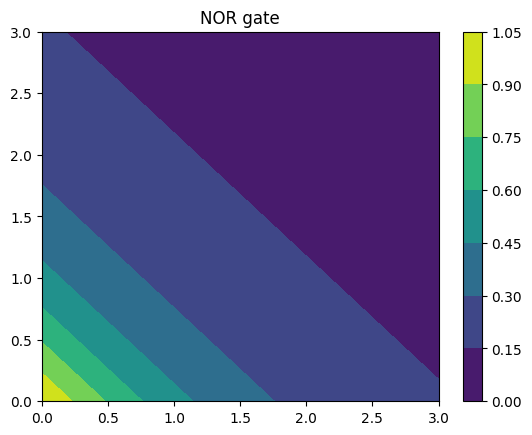

In [242]:
def contour_fun(x: np.ndarray, y: np.ndarray, z: np.ndarray, title: str | None=None):
    """
    Make a filled contour plot given x, y, z
    in 2D arrays.
    """
    plt.figure()
    CS = plt.contourf(x, y, z)
    plt.colorbar(CS)
    if title is not None:
        plt.title(title)


# Get x and y values for plotting
x = np.linspace(0, 3, 200)
y = np.linspace(0, 3, 200)
xx, yy = np.meshgrid(x, y)

# Parameters (Hill functions)
# increase them to make it more digital
nx: float = 1.5  # 3.0
ny: float = 1.5  # 3.0

def nor(x: np.ndarray, y: np.ndarray, nx: float, ny: float):
    return 1 / (1 + (x+y) ** nx)

contour_fun(
    xx, yy,
    nor(xx, yy, nx, ny),
    title="NOR gate"
)

However, in case of the linear composition as a sum of inputs, plotting the Hill curve directly is more informative.
The resulting curve looks like an `INV` transfer characteristics we saw before.

### Tandem Promoter Design

A different approach is to combine two input promoters in tandem. 
This approach is used in [Cello 2.0](https://www.nature.com/articles/s41596-021-00675-2) together with the Split gate approach.

The resulting `NOR` design looks like this:

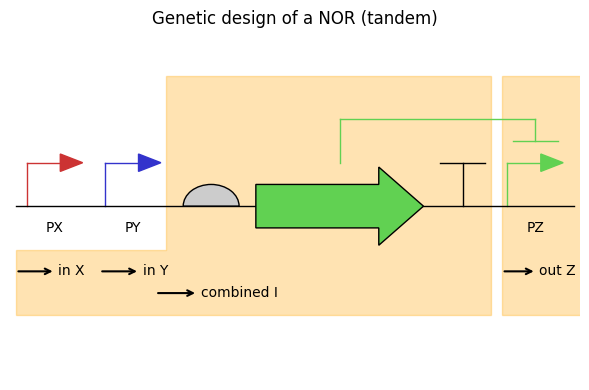

In [243]:
# --- Define design ---
# --- A gate ---
pX = {
        'type': 'Promoter',
        'fwd': True,
        'opts': {
            'label':'PX',
            'color':[0.8, 0.2, 0.2],
            'label_size':10,
            'label_y_offset': -5
        },
    }
pY = {
        'type': 'Promoter',
        'fwd': True,
        'opts': {
            'label':'PY',
            'color':[0.2, 0.2, 0.8],
            'label_size':10,
            'label_y_offset': -5
        },
    }
rbs0 = {
        'type': 'RBS',
        'fwd': True,
        'opts': {
            'color':[0.8, 0.8, 0.8],
        }
    }
cds0 = {
        'type': 'CDS',
        'fwd': True,
        'opts': {
            'color':[0.38, 0.82, 0.32],
            'label_size':10
        },
    }
t0 = {
        'type': 'Terminator',
        'fwd': True,
    }

# --- output ---
pZ = {
        'type': 'Promoter',
        'fwd': True,
        'opts': {
            'label':'PZ',
            'label_size':10,
            'label_y_offset': -5,
            'color': [0.38, 0.82, 0.32],
        },
    }


# --- Define regulation ---
regulations = [
    {
        'from_part': cds0,
        'to_part': pZ,
        'type': 'Repression',
        'opts': {
            'color': [0.38, 0.82, 0.32],
        }
    }
]

design = [
    pX, pY, rbs0, cds0, t0,
    pZ,
]

# --- Render DNA ---
fig, ax = plt.subplots(figsize=(6, 4))

# orange gate boxes
gate_x = [0, 0, 85, 85, 27, 27]
gate_y = [-10, -25, -25, 30, 30, -10]
ax.fill(gate_x, gate_y, color='orange', alpha=0.3)

gate_x2 = [87, 87, 142, 142]
gate_y2 = [30, -25, -25, 30]
ax.fill(gate_x2, gate_y2, color='orange', alpha=0.3)

start_pos, end_pos = dr.renderDNA(
    ax=ax,
    parts=design,
    regs=regulations,
    part_renderers=renderers,
    reg_renderers= dr.std_reg_renderers(),
)

ax.annotate(
    'in X',
    xy=(0, -15),
    xytext=(10, -15),
    arrowprops=dict(arrowstyle="<-", color='black', lw=1.5),
    fontsize=10,
    ha='center',
    va='center'
)
ax.annotate(
    'in Y',
    xy=(15, -15),
    xytext=(25, -15),
    arrowprops=dict(arrowstyle="<-", color='black', lw=1.5),
    fontsize=10,
    ha='center',
    va='center'
)
ax.annotate(
    'combined I',
    xy=(25, -20),
    xytext=(40, -20),
    arrowprops=dict(arrowstyle="<-", color='black', lw=1.5),
    fontsize=10,
    ha='center',
    va='center'
)
ax.annotate(
    'out Z',
    xy=(87, -15),
    xytext=(97, -15),
    arrowprops=dict(arrowstyle="<-", color='black', lw=1.5),
    fontsize=10,
    ha='center',
    va='center'
)

ax.set_xlim(start_pos - 1, end_pos + 1)
ax.set_ylim(-40, 40)
ax.set_axis_off()
plt.title("Genetic design of a NOR (tandem)")
plt.tight_layout()

This design is called the __Tandem Promoter__ design. The input promoters are not part of the design and are provided the previous gate. The design comprises of an RBS, a CDS for the repressor (green in the picture), a terminator, and the output promoter PZ. 

In the simplest case, inputs $X$ and $Y$ (as before, in terms of promoter activity) are again summed to yield the combined activity $I$. The idea is that both promoters lead to a certain activity (say in RNAP/s) and that these activities do not interfere.
Then we can apply the transfer characteristics of an `INV`, which is a Hill function.
Together, we obtain:

\begin{align}
  I(X, Y) &= X + Y\\
  Z(I) &= Z_{\min} + \frac{Z_{\max} - Z_{\min}}{1+(I/K_\mathrm{d})^n}
\end{align}

Different combinations of input activities have been proposed to account for interference such as an effect called roadblock.
This ranges from weighted sums to more complex Hill-type functions.
For example, Cello 2.0 allows the use of a non-linear roadblock model as described in the work by [Jones, Oliveira, Myers, Voigt, and Densmore](https://www.nature.com/articles/s41596-021-00675-2).

The process has 3 steps and is iterated from the inputs to the outputs of the circuit:
1. __Input composition__: Inputs $X$ and $Y$ are linearly combined. This is either by the sum
  \begin{align}
  I = X + Y
  \end{align}
  or by the weighted sum using a tandem factor $tf_Y$ from a previous iteration
  \begin{align}
  I = \text{tf}_Y \cdot X + Y
  \end{align}
  The factor accounts for the first promoter activity being blocked by the repressor at the second promoter PY. This factor thus depends on properties of the Y system.

2. __Tandem interference factor__: The combined activity $I$ is used to compute the tandem factor $\text{tf}_Z$ for the Z system.
  \begin{align}
  \text{tf}_Z = \alpha\frac{K^n + \beta I^n}{K^n + I^n}
  \end{align}
  Parameters $\alpha$, $\beta$, $K$, and $n$ are provided by a characterization of the gate.
  Observe that with a low input $I = 0$, it is $\text{tf}_Z = \alpha$.
  In presence of a high input $I \to \infty$, we have $\text{tf}_Z = \alpha \beta$.
  Typically $\alpha, \beta \in [0,1]$ and $\alpha \approx 1$ and $\beta$ well below $1$ to show dynamic roadblocking.
  When choosing $\beta = 1$ and $\alpha < 1$, only static roadblocking is accounted for ($\text{tf}_Z$ is constant).
  In case PZ is used as a second promoter in a downstream gate, the factor will block the first promoter activity.

3. __Inverter transfer function__: Finally, the transfer function is applied, yielding
  \begin{align}
  Z = y_{\min} + \frac{y_{\max} - y_{\min}}{1 + (I/K)^n}
  \end{align}
  The additional parameters $y_{\min}$ and $y_{\max}$ are again provided by a characterization of the gate.



Let us plot an example tandem blocking factor curve to see the dependency of the blocking on the combined input promoter activity.

Text(0.5, 1.0, 'Tandem Blocking Factor')

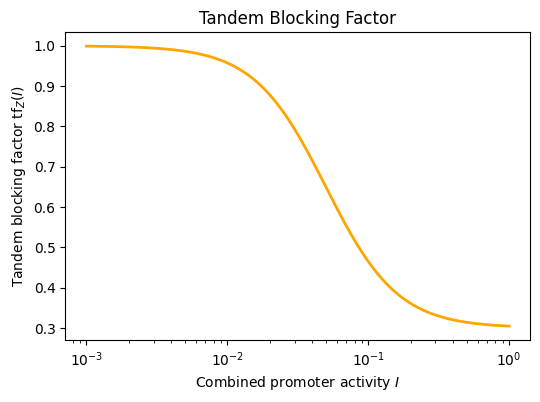

In [244]:
# Parameters (K, n are approximate from the Cello 2.0 A1_AmtR_model)
K = 0.05
n = 1.7
alpha = 1
beta = 0.3

# I range (log scale to see low and high I clearly)
I = np.logspace(-3, 0, 200)

# Tandem blocking factor
tf_Z = alpha * (K**n + beta * I**n) / (K**n + I**n)

# Plot
plt.figure(figsize=(6,4))
plt.plot(I, tf_Z, lw=2, color='orange')
plt.xscale('log')
plt.xlabel(r'Combined promoter activity $I$')
plt.ylabel(r'Tandem blocking factor $\text{tf}_Z(I)$')
plt.title('Tandem Blocking Factor')

The curve clearly shows the two extremes of $\alpha = 1$ on the left and $\alpha \cdot \beta = 0.3$ on the right.

# The Feed Forward Loop (FFL)

A motive commonly found in cells like _E. coli_ is the so called feed forward loop (FFL).
The name is unfortunately misleading since it has convergent paths, but not a loop - we will
nonetheless use it since it is established in literature.

The motive comprises of 3 species, let's call them $X,Y,Z$, and three interactions among them
along two paths:

\begin{align}
&X \rightarrow Y \rightarrow Z\\
&X \quad \rightarrow \quad Z
\end{align}

We think of $X$ as a circuit input and $Z$ as its output. 
Interactions can be activating and repressing, which we will denote by
$X \to Y$ for an _activating_ interaction and $X -\mid Y$ for a _repressing_ interaction
of $X$ on $Y$.

We say a path is *activating* if the number of repressing interacting along it is even.
It is *repressing* otherwise.

Following literature, we call an FFL *coherent* if both paths are either activating or repressing and
*incoherent* if one is repressing and the other activating.


## Classification

There are a total of $2^3 = 8$ different FFLs depending on which of the interactions are activating and repressing. All are shown below, in a figure taken from [Alon, *Nature Rev. Genet.*, 2007](https://doi.org/10.1038/nrg2102). 

<div style="width: 500px; margin: auto">

<figure style="width: 100%; margin: auto; padding: 20px;">
  <img src="figs/FFL_classes.png" alt="FFL classes">
</figure>
    
</div>

The figure also indicates common abbreviations for these circuits: e.g., C2-FFL is the coherent FFL of type 2 and I4-FFL is the incoherent FFL of type 4.


## The most-encountered FFLs

While FFLs in general are motifs, some FFLs are more often encountered than others. In the figure below, also taken from [the Alon review](https://doi.org/10.1038/nrg2102), we see relative abundance of the eight different FFLs in *E. coli* and *S. cerevisiae*. Two FFLs, C1-FFL and I1-FFL stand out as having much higher abundance than the other six. 

We will take a look at these two FFLs in turn to see what features they might provide. First, though, we need to consider the **logic of regulation** by more than one transcription factor.

## Logic of regulation by two transcription factors

Because X and Y both regulate Z in an FFL, we need to specify how they do that.
For the sake of illustration, let us assume we are discussing C1-FFL, where

$$
Y \rightarrow Z\\
X \rightarrow Z
$$

We distinguish between two semantics:
* One can imagine a scenario where both X and Y need to be present to turn on Z. For example, they could be binding partners that together serve to recruit polymerase to the promoter.
  To get expression of Z, we must have `X AND Y`.

* Conversely, if either X or Y may each alone activate Z, we have that Z is expressed if `X OR Y`.

So, to fully specify an FFL, we need to also specify the logic of how Z is regulated.

An other example is the case where

$$
Y -\mid Z\\
X -\mid Z
$$

and the composition is via an `AND` resulting in `(NOT X) AND (NOT Y) = NOR(X,Y)`; a gate that we know from before.


### Logic with two activators

Assume that $z = f_{AND}(x,y)$ is the normalized (within $[0,1]$) steady state input-output behavior of `Z = X AND Y`.
Likewise, $z = f_{OR}(x,y)$ is the normalized steady state input-output behavior of `Z = X OR Y`.


Let $f$ be either $f_{AND}$ or $f_{OR}$.
Using a simple 1st-order dynamic model as an approach, the concentration of $Z$ follows:

\begin{align}
\frac{\mathrm{d}z}{\mathrm{d}t} = \beta_0\,f(x, y) - \gamma z\enspace,
\end{align}

where $\beta_0$ is the maximal production rate and
$\gamma$ is its degradation/dilution rate.

Our goal is to specify the dimensionless function $f(x, y)$ that encodes the appropriate logical functions.
There are two ways we can come up with a candidate function:
* We could derive the functional form from the molecular details of the promoter region and the activators. 
  We will however, not follow this modeling path for the moment.

* We can use a phenomenological, generalized Hill function and parametrize it to experimental data.

One possible generalization to two inputs is to form the `AND` by multiplying and the `OR` by adding
$(X/K_\mathrm{d})^n$ terms as follows:

\begin{align}
f_{AND}(x,y) &= \frac{(x/K_x)^{n_x} (y/K_y)^{n_y}}{1 + (x/K_x)^{n_x} (y/K_y)^{n_y}}\\[1em]
f_{OR}(x,y) &= \frac{(x/K_x)^{n_x} + (y/K_y)^{n_y}}{1 + (x/K_x)^{n_x} + (y/K_y)^{n_y}} \enspace.
\end{align}

> **_Side note:_** The choice of the functions is somewhat arbitrary now, but fulfills some basic constraints that we expect to hold. For example, for `AND`, we would like limits $x,y \to \infty$ (i.e., both inputs logically 1) result in $1$ and $x = 0$ or $y = 0$ (one of the inputs being logically 0) result in $0$. One readily verifies that this is the case.

In what follows, we will substitute $x/K_x \to x$ and $y/K_y \to y$. This is just for simplicity.
Note that now, $x$ and $y$ are dimensionless.

\begin{align}
f_{AND}(x,y) &= \frac{x^{n_x} y^{n_y}}{1 + x^{n_x} y^{n_y}}\\[1em]
f_{OR}(x,y)  &= \frac{x^{n_x} + y^{n_y}}{1 + x^{n_x} + y^{n_y}} \enspace.
\end{align}

We can make plots of these functions to demonstrate how they represent the respective logic.

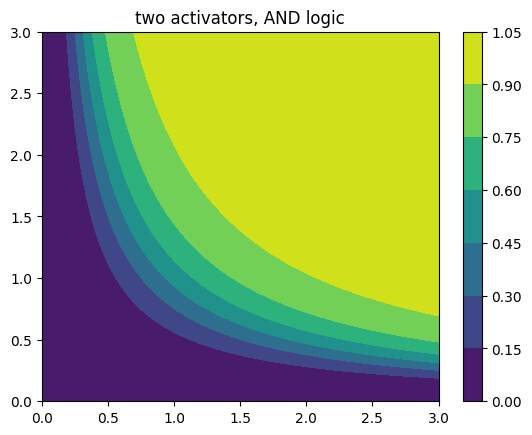

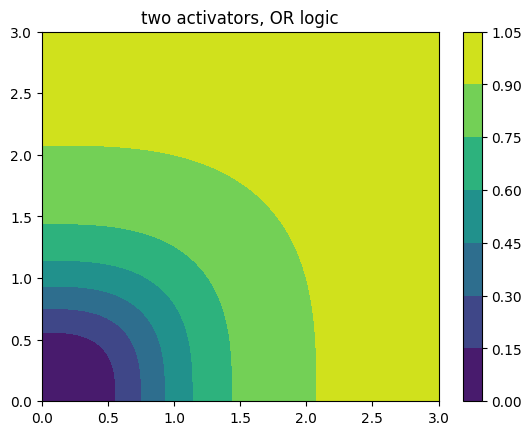

In [245]:
# Get x and y values for plotting
x = np.linspace(0, 3, 200)
y = np.linspace(0, 3, 200)
xx, yy = np.meshgrid(x, y)

# Parameters (Hill functions)
# increase them to make it more digital
nx: float = 3.0  # 20.0
ny: float = 3.0  # 20.0

# Regulation functions
def aa_and(x: np.ndarray, y: np.ndarray, nx: float, ny: float):
    comb = x ** nx * y ** ny
    return  comb / (1 + comb)


def aa_or(x: np.ndarray, y: np.ndarray, nx: float, ny: float):
    comb = x ** nx + y ** ny
    return comb / (1 + comb)

# plot it
contour_fun(xx, yy,
            aa_and(xx, yy, nx, ny),
            title="two activators, AND logic")

contour_fun(xx, yy,
            aa_or(xx, yy, nx, ny),
            title="two activators, OR logic")

### Same with two repressors

We can do the same with two repressors instead of two actovators.
The `AND` case where X and Y are both repressors is `(NOT X) AND (NOT Y) = NOR(X,Y)`.
Here, either repressor (or both) can shut down gene expression.

For the `OR` of two repressors, we have `(NOT X) OR (NOT Y) = NAND(X,Y)`.

Functions that fulfill these requirements are:
\begin{align}
f_{NOR}(x,y)  &= \frac{1}{(1 + x^{n_x}) (1 + y^{n_y})}\\[1em]
f_{NAND}(x,y) &= \frac{1 + x^{n_x} + y^{n_y}}{(1 + x^{n_x}) ( 1 + y^{n_y})}
\end{align}

> **_Side note_:** The $f_{NOR}(x,y)$ function is different from the one we used to model the `NOR`. First, we use a model with concentrations to rates, here. Second, this function is mechanistically motivated from a repressor that blocks if it is bound to either of the promoter sites.
> This results in the two repression Monod terms being multiplied.
>
> In the `NOR` gate with Tandem Promoters, we had only the right promoter blocking the left one but not the left one blocking the right one.
> The the split gate, we even added both activities.
>
> When modeling, we thus have to be careful what the underlying mechanism is.

### Logic with one activator and one repressor

We can also mix activation and repression. Calling the activator $A$ and the repressor $R$, `AND` logic means `A AND (NOT R)`, and `OR` logic means `A OR (NOT R)`.

Possible dimensionless regulatory functions are

\begin{align}
f_{ANDNOT}(x,y) &= \frac{x^{n_x}}{1 + x^{n_x} + y^{n_y}}\\[1em]
f_{ORNOT}(x,y) &= \frac{1 + x^{n_x}}{1 + x^{n_x} + y^{n_y}}
\end{align}


with the following plots

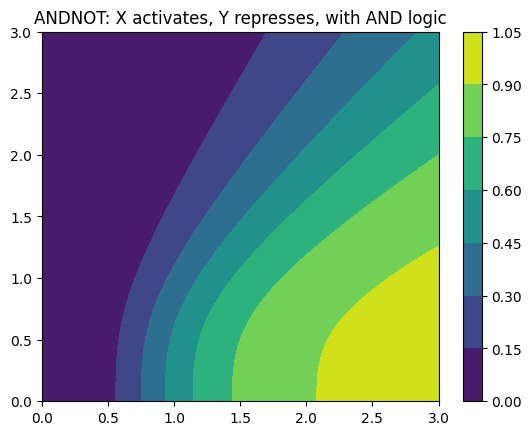

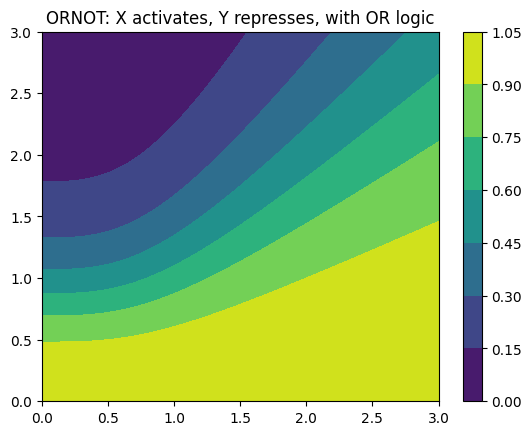

In [246]:
# Regulation functions
def ar_and(x, y, nx, ny):
    return x ** nx / (1 + x ** nx + y ** ny)


def ar_or(x, y, nx, ny):
    return (1 + x ** nx) / (1 + x ** nx + y ** ny)

# Parameters (Hill functions)
# increase them to make it more digital
nx = 3  # 20
ny = 3  # 20

# Generate plots
contour_fun(xx, yy,
            ar_and(xx, yy, nx, ny),
            title="ANDNOT: X activates, Y represses, with AND logic")

contour_fun(xx, yy,
            ar_or(xx, yy, nx, ny),
            title="ORNOT: X activates, Y represses, with OR logic")

## Numerical solution of the FFL circuits

To specify the dynamical equations so that we may numerically solve them, we need to specify the functions $f_y$ and $f_z$ along with their Hill coefficients. The function $f_y$ is either an activating or repressive Hill function, and the functions $f_z$ have already been defined as `aa_and()`, `aa_or()`, etc., above.

Let's proceed to code up the right-hand side of the dynamical equations for FFLs. It is convenient to define a function that will give back a function that we can use as the right-hand side we need to specify to `scipy.integrate.odeint()`. Remember that `odeint()` requires a function of the form `func(yz, t, *args)`, where `yz` is an array containing the values of $y$ and $z$. For convenience, our function will return a function with call signature `rhs(yz, t, x)`, where `x` is the value of $x$ at a given time point.

In [247]:
# Regulation functions
def a_hill(x, nx):
    comb = x ** nx
    return  comb / (1 + comb)


def r_hill(x, nx):
    comb = x ** nx
    return 1 / (1 + comb)


# get FFL functions
def ffl_rhs(beta, gamma, kappa, n_xy, n_xz, n_yz, ffl, logic):
    """Return a function with call signature fun(yz, x) that computes
    the right-hand side of the dynamical system for an FFL. Here,
    `yz` is a length two array containing concentrations of Y and Z.
    """
    if ffl[:2].lower() in ("c1", "c3", "i1", "i3"):
        fy = lambda x: a_hill(x, n_xy)
    else:
        fy = lambda x: r_hill(x, n_xy)

    if ffl[:2].lower() in ("c1", "i4"):
        if logic.lower() == "and":
            fz = lambda x, y: aa_and(x, y, n_xz, n_yz)
        else:
            fz = lambda x, y: aa_or(x, y, n_xz, n_yz)
    elif ffl[:2].lower() in ("c4", "i1"):
        if logic.lower() == "and":
            fz = lambda x, y: ar_and(x, y, n_xz, n_yz)
        else:
            fz = lambda x, y: ar_or(x, y, n_xz, n_yz)
    elif ffl[:2].lower() in ("c2", "i3"):
        if logic.lower() == "and":
            fz = lambda x, y: ar_and(y, x, n_yz, n_xz)
        else:
            fz = lambda x, y: ar_or(y, x, n_yz, n_xz)
    else:
        if logic.lower() == "and":
            fz = lambda x, y: rr_and(x, y, n_xz, n_yz)
        else:
            fz = lambda x, y: rr_or(x, y, n_xz, n_yz)

    def rhs(yz, t, x):
        y, z = yz
        dy_dt = beta * fy(kappa * x) - y
        dz_dt = gamma * (fz(x, y) - z)

        return np.array([dy_dt, dz_dt])

    return rhs

To study the dynamics, we will investigate how the circuit responds to a step up in concentration of X, assuming all concentrations are initially zero, and how a circuit at steady state with nonzero concentration of X responds to a step down in X to zero.

In [248]:
def solve_ffl(
    beta, gamma, kappa, n_xy, n_xz, n_yz, ffl, logic, t, t_step_down, x_0
):
    """Solve an FFL. The dynamics are given by
    `rhs`, the output of `ffl_rhs()`.
    """
    if t[0] != 0:
        raise RuntimeError("time must start at zero.")

    rhs = ffl_rhs(beta, gamma, kappa, n_xy, n_xz, n_yz, ffl, logic)

    # Integrate if we do not step down
    if t[-1] < t_step_down:
        return scipy.integrate.odeint(rhs, np.zeros(2), t, args=(x_0,))

    # Integrate up to step down
    t_during_step = np.concatenate((t[t < t_step_down], (t_step_down,)))
    yz_during_step = scipy.integrate.odeint(
        rhs, np.zeros(2), t_during_step, args=(x_0,)
    )

    # Integrate after step
    t_after_step = np.concatenate(((t_step_down,), t[t > t_step_down]))
    yz_after_step = scipy.integrate.odeint(
        rhs, yz_during_step[-1, :], t_after_step, args=(0,)
    )

    # Concatenate solutions
    if t_step_down in t:
        return np.vstack((yz_during_step[:-1, :], yz_after_step))
    else:
        return np.vstack((yz_during_step[:-1, :], yz_after_step[1:, :]))

Finally, we can write a function to solve and plot the dynamics of an FFL for a unit step.  
At the end of this notebook, we have a dashboard to explore the C1-FFL and I1-FFL, but for the pedagogical purposes of exposing design principles here, we will vary the parameters one-by-one as we work down the notebook.

In [249]:
colors = ['red', 'green', 'blue']

def plot_ffl(
    beta=1.0,
    gamma=1.0,
    kappa=1.0,
    n_xy=1.0,
    n_xz=1.0,
    n_yz=1.0,
    ffl="c1",
    logic="and",
    t=np.linspace(0, 20, 200),
    t_step_down=10.0,
    x_0=1.0,
    normalized=False,
):
    yz = solve_ffl(
        beta, gamma, kappa, n_xy, n_xz, n_yz, ffl, logic, t, t_step_down, x_0
    )
    y, z = yz.transpose()

    # Generate x-values
    if t[-1] > t_step_down:
        t_x = np.array(
            [-t_step_down / 10, 0, 0, t_step_down, t_step_down, t[-1]]
        )
        x = np.array([0, 0, x_0, x_0, 0, 0])
    else:
        t_x = np.array([-t[-1] / 10, 0, 0, t[-1]])
        x = np.array([0, 0, x_0, x_0])

    # Add left part of y and z-values
    t = np.concatenate(((t_x[0],), t))
    y = np.concatenate(((0,), y))
    z = np.concatenate(((0,), z))

    # Set up figure
    plt.figure()
    plt.xlabel("dimensionless time")
    plt.ylabel(f"{'norm. ' if normalized else ''}dimensionless conc.")

    if normalized:
        x = x / x.max()
        y = y / y.max()
        z = z / z.max()
    
    plt.plot(t_x, x, color=colors[0], label="x")
    plt.plot(t, y, color=colors[1], label="y")
    plt.plot(t, z, color=colors[2], label="z")

    plt.legend()

## C1-FFL with AND: Sign-sensitive delay

Now that we have laid the computational groundwork, we will proceed to an analysis of the first of the two over-represented FFLs, the C1-FFL. For reference, the dimensionless dynamical equations are

\begin{align}
\frac{\mathrm{d}y}{\mathrm{d}t} &= \beta\,\frac{(\kappa x)^{n_{xy}}}{1 + (\kappa x)^{n_{xy}}} - y, \\[1em]
\gamma^{-1}\frac{\mathrm{d}z}{\mathrm{d}t} &= \frac{x^{n_{xz}} y^{n_{yz}}}{1 + x^{n_{xz}} y^{n_{yz}}} - z.
\end{align}

Now, let's look at the dynamics for a sudden step up and step down in X.

With these convenient functions available, we can now specify parameters, solve, and plot.

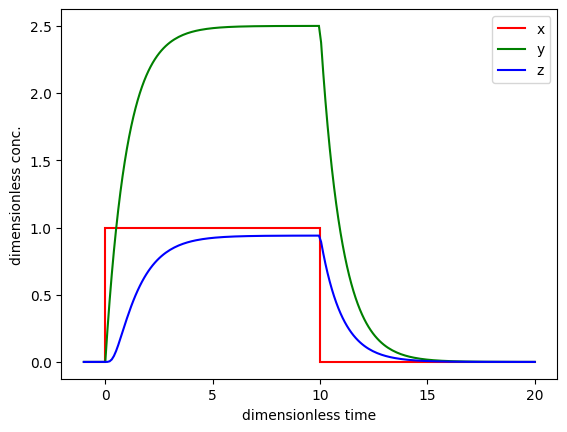

In [250]:
# Parameter values
beta = 5
gamma = 1
kappa = 1
n_xy, n_yz = 3, 3
n_xz = 5

# Plot
plot_ffl(beta, gamma, kappa, n_xy, n_xz, n_yz, ffl="c1", logic="and")

Notice that there is a time delay for production of $Z$ upon stimulation with $X$. This is a result of the `AND` logic. Though $X$ has immediately come up, we have to wait for the signal to pass through $Y$ for $Z$ to come up. This off-response is perhaps more apparent if we normalize the signals.

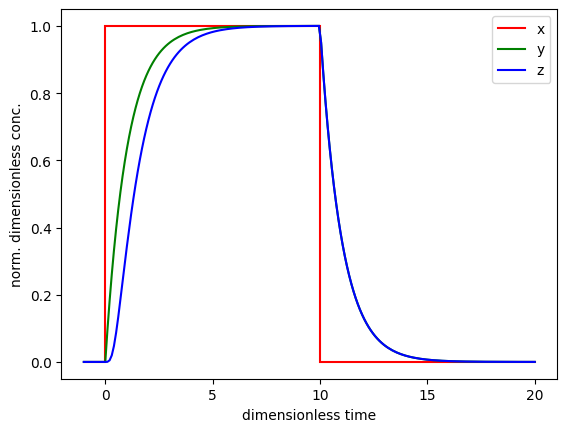

In [251]:
plot_ffl(
        beta,
        gamma,
        kappa,
        n_xy,
        n_xz,
        n_yz,
        ffl="c1",
        logic="and",
        normalized=True,
)

Here, the delay is more apparent, as is the fact that both Y and Z have their levels immediately decrease when the X stimulus is removed. So, we have arrived at a design principle: **The C1-FFL with AND logic has an on-delay, but no off-delay.**

### The magnitude of the delay can be tuned

How might we get a longer delay? If we decrease $\kappa = k_{xz}/k_{yz}$, we are increasing the disparity between the threshold levels needed to turn on gene expression. This should result in a longer time delay. Let's try it!

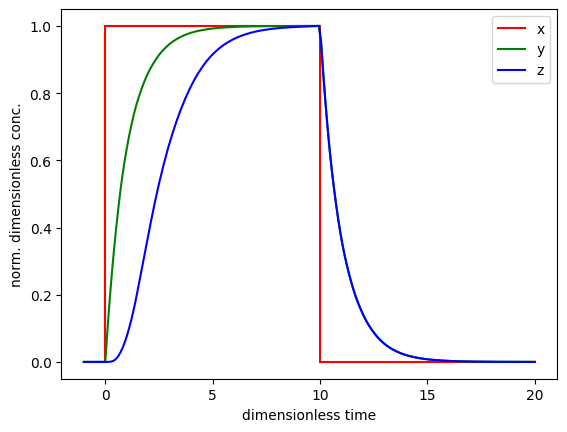

In [252]:
# Update parameter
kappa = 0.001

plot_ffl(
        beta,
        gamma,
        kappa,
        n_xy,
        n_xz,
        n_yz,
        ffl="c1",
        logic="and",
        normalized=True
)

### Making a sweep

Indeed, the delay is longer with small *$\kappa$*. We can quantify how the delay changes with $\kappa$ by plotting how long it takes for the $z$ level to rise to ten percent of its steady state value for various values of $\kappa$.

(0.0, 5.0)

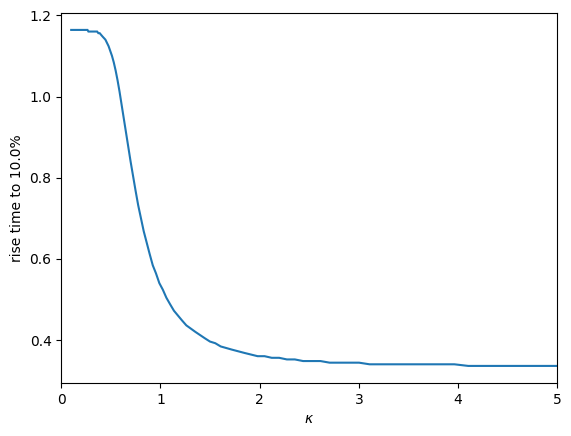

In [253]:
THRESHOLD_FRACTION = 0.1  # 10% of steady state

tau = []
kappa_vals = np.logspace(-1, 2, 200)

# Finer time points
t_ = np.linspace(0, 20, 5000)

for kappa in kappa_vals:
    yz = solve_ffl(
        beta, gamma, kappa, n_xy, n_xz, n_yz, "c1", "and", t_, np.inf, 1
    )
    z_thresh = yz[-1, 1] * THRESHOLD_FRACTION
    i = np.nonzero(yz[:, 1] > z_thresh)[0][0]
    tau.append(t_[i])
    
plt.figure()
plt.plot(kappa_vals, tau)
plt.xlabel(r'$\kappa$')
plt.ylabel(f'rise time to {THRESHOLD_FRACTION*100}%')
plt.xlim([0,5])

The delay does not change substantially, only about a factor of three over many orders of magnitude.

### Short Pulse Filter

Now, let's see what happens if we have a shorter pulse. Due to its similarly with the cascade we previously studied, the delay feature of the C1-FFl should also filter our short pulses.

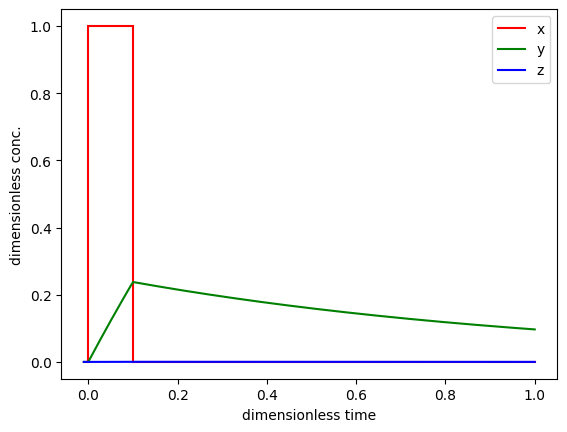

In [254]:
# Shorter pulse
t = np.linspace(0, 1, 200)
t_step_down = 0.1

# Reset kappa and ultrasensitivity
kappa = 1
n_xy, n_xz, n_yz = 3, 5, 3

plot_ffl(
        beta,
        gamma,
        kappa,
        n_xy,
        n_xz,
        n_yz,
        ffl="c1",
        logic="and",
        t=t,
        t_step_down=t_step_down,
        normalized=False,
)

The shorter pulse is ignored in the Z-response because of the delay.

### The sign-sensitivity of the delay is reversed with OR logic

We will now investigate the response of the circuit to the same stimulus, except with `OR` logic.

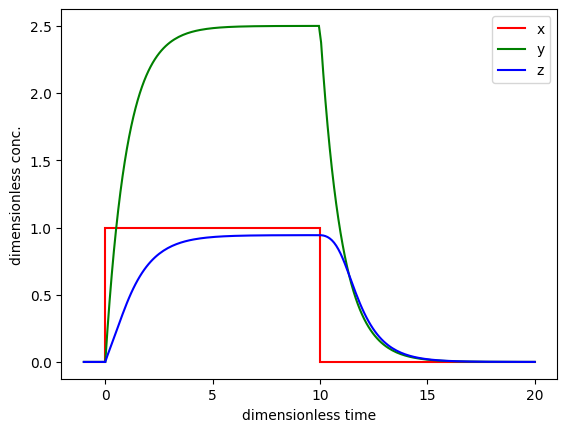

In [255]:
plot_ffl(
        beta,
        gamma,
        kappa,
        n_xy,
        n_xz,
        n_yz,
        ffl="c1",
        logic="or",
        normalized=False,
)

Again, let's normalize to see it more clearly:

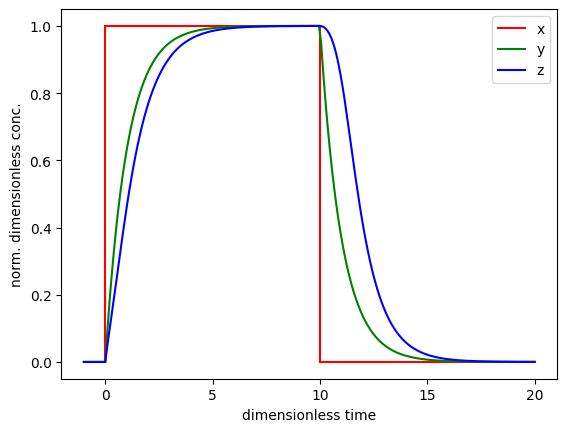

In [256]:
plot_ffl(
        beta,
        gamma,
        kappa,
        n_xy,
        n_xz,
        n_yz,
        ffl="c1",
        logic="or",
        normalized=True,
)

### Sign sensitive delay is observed experimentally

The arabinose and lac systems in *E. coli* are both turned on by cyclic AMP (cAMP), which stimulates production of CRP, but they have different architectures, shown below.

<div style="width: 300px; margin: auto">

<figure style="width: 100%; margin: auto; padding: 20px;">
  <img src="figs/araBAD_lacZYA_systems.png" alt="araBAD and lacZYA">
</figure>

</div>

In both system where multiple species regulate one, AND logic is employed.

Mangan an coworkers ([*J. Molec. Biol.*, 2003](https://doi.org/10.1016/j.jmb.2003.09.049)) performed an experiment where they put a fluorescent reporter under control of the products of these two systems, araBAD and lacZYA, respectively. In the lac system, IPTG was also present, so LacI was inhibited. Thus, lacZYA production was directly activated by CRP. Conversely, the arabinose system is a C1-FFL. 

They measured the fluorescent intensity in cells that were suddenly exposed to cAMP. The response of these two systems to the sudden jump in cAMP is shown in the left plot below.

<div style="width: 550px; margin: auto">

<figure style="width: 100%; margin: auto; padding: 20px;">
  <img src="figs/alon_lacZYA_araBAD_cffl.png" alt="response to steps">
</figure>

</div>

While the lac system response immediately, the arabinose system exhibits a lag before responding. This is indicative of a time delay for a step *on* in the stimulus for a C1-FFL. Conversely, after these systems come to steady state and are subjected to a sudden decrease in cAMP, both the arabinose and lac systems respond immediately, without delay, which is also expected from a C1-FFL with `AND` logic.

Kalir and coworkers ([*Mol. Sys. Biol.*, 2005](https://doi.org/10.1038/msb4100010)) did a similar experiment with another C1-FFL circuit found in *E. coli*, this time with `OR` logic. A circuit that regulates flagella formation is a "decorated" C1-FFL, shown below. We say it is decorated because the "Y" gene, in this case FliA, is also autoregulated. Importantly, the regulation of FliL by FliA and FlhDC is governed by `OR` logic.

<div style="width: 300px; margin: auto">

<figure style="width: 100%; margin: auto; padding: 20px;">
  <img src="figs/fliA_system.png" alt="fliA system">
</figure>

</div>

Kalir and coworkers used engineered cells in which the FlhDC gene was under control of a promoter which could be induced with L-arabinose, a chemical inducer. The gene product FliL was altered to be fused to GFP to enable fluorescent monitoring of expression levels. To consider a circuit where FlhDC directly activates FliL, Kalir and coworkers used mutant *E. coli* cells in which the *fliA* gene was deleted.

Because of the `OR` logic, we would expect that a sudden increase in FlhDC would result in both the wild type and mutant cells to respond at the same time, that is with no delay. Fluorescence traces from these experiments are shown in the left plot, below.

<div style="width: 550px; margin: auto">

<figure style="width: 100%; margin: auto; padding: 20px;">
  <img src="figs/alon_fliA_cffl.png" alt="response to steps fliA">
</figure>

</div>

Both strains show a delay, which is due to waiting for FlhDC to be activated, but both come on at the same time. Conversely, after the inducer is removed and FlhDC levels go down, the system with the wild type C1-FFL circuit shows a delay before the FliL levels drop off, while the mutant does not. This demonstrates the sign-sensitivity with `OR` logic.

## I1-FFL with AND: Pulse Generator

We now turn our attention to the other over-represented circuit, the I1-FFL. As a reminder, here is the structure of the circuit.

<div style="width: 150px; margin: auto; margin-top: 20px">

<figure style="width: 100%; margin: auto; padding: 20px;">
  <img src="figs/i1-ffl.png" alt="FFL abundance">
</figure>

</div>

X activates Y and Z, but Y represses Z. We can use the expressions for production rate under `AND` and `OR` logic for one activator/one repressor that we showed above in writing down our dynamical equations. Here, we will consider `AND` logic. The dimensionless dynamical equations are

\begin{align}
\frac{\mathrm{d}y}{\mathrm{d}t} &= \beta\,\frac{(\kappa x)^{n_{xy}}}{1+(\kappa x)^{n_{xy}}} - y,\\[1em]
\gamma^{-1}\,\frac{\mathrm{d}z}{\mathrm{d}t} &= \frac{x^{n_{xz}}}{(1 + x^{n_{xz}} + y^{n_{yz}})} - z.
\end{align}

For this circuit, we will investigate the response in Z to a sudden, sustained step in stimulus X. We will choose $\gamma = 10$, which means that the dynamics of Z are faster than Y.

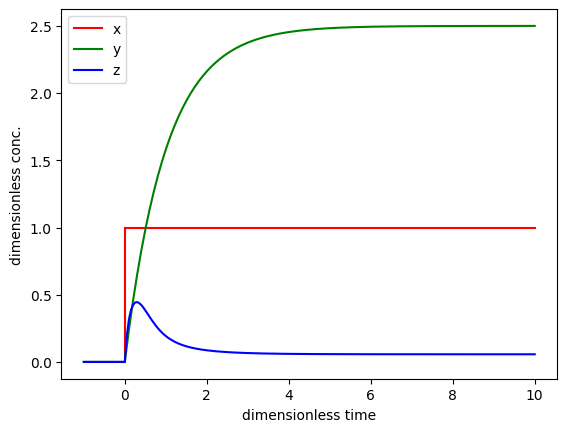

In [257]:
# Parameter values
beta = 5
gamma = 10
kappa = 1
n_xy, n_yz = 3, 3
n_xz = 5
t = np.linspace(0, 10, 200)

# Set up and solve
plot_ffl(
        beta,
        gamma,
        kappa,
        n_xy,
        n_xz,
        n_yz,
        ffl="i1",
        logic="and",
        t=t,
        t_step_down=np.inf,
        normalized=False,
)

We see that Z pulses up and then falls down to its steady state value. This is because the presence  X leads to production of Z due to its activation. X also leads to the increase in Y, and once enough Y is present, it can start to repress Z. This brings the Z level back down toward a new steady state where the production rate of Z is a balance between activation by X and repression by Y. Thus, **the I1-FFL with `AND` logic is a pulse generator.**

---
**License & Attribution**: This page is from material by [Michael Elowitz and Justin Bois](https://biocircuits.github.io/) (© 2021–2025), licensed under [CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/), with minor modifications.